# Turbulence Development Over Complex Terrain
This notebook contains the necessary code to analyze the SOWFA simulations that are used to determine the effectiveness of terrain in generating turbulence.

## Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sowfadict as sowfa
import subprocess
import tools
from scipy.stats import norm
from scipy.stats import skew,kurtosis
import pandas as pd

## Declare user variables (cases, towers, colors, etc.)

In [20]:
varns   = ['u','v','w','T']
cases   = ['M2_SR_Control','M2_SR_NoTurbBC']#,'M2_diff2_TurbBC','M2_diff2_NoTurbBC']
casec   = ['navy','darkturquoise','red','goldenrod']
casece  = [casec[0],'none',casec[2],'none']
casecf  = ['none',casec[1],'none',casec[3]]
casem   = ['o','o','d','d']
x = np.arange(0,101)
caselw  = ['3','2','3','2']
casea   = [0.8,1.0,0.8,1.0]
casesz  = [50,15,50,15]
nvars   = np.shape(varns)[0]
ncases  = np.shape(cases)[0]
timedir = 14400
avgstart = 1799 # when do you want to start the averaging?
avgend   = -1 # when do you want to end the averaging?
lvl     = 5
twrs    = [1,3,5,7]
ntwrs   = np.shape(twrs)[0]

## Load in the data and store for manipulation & plotting

In [75]:
initIndividualTowerVars = True
initAvgTowerVars        = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        for vv in range(0,nvars):
            var = varns[vv]
            fdir      = '/projects/mmc/NWTCRegion/NWTC.run.%s/postProcessing/' % (cases[cc]) 
            pl        = 'probeLine%d' % twrs[tt]
            probeLine = sowfa.probeLine('%s%s/%d/' % (fdir,pl,timedir),'y',['U','T'])
            dt        = np.mean(probeLine.time[1:] - probeLine.time[:-1])
            ntwr      = probeLine.ntowers; ntwrsq = int(np.sqrt(ntwr))
            if tt == 0: 
                tdz        = np.mean(probeLine.z[0,1:] - probeLine.z[0,:-1]) 
                twrheight  = probeLine.z[0,lvl] - probeLine.z[0,0] + tdz/2.0
                twrheightf = probeLine.z[0,:] - probeLine.z[0,0] + tdz/2.0
            for tw in np.arange(0,probeLine.ntowers):
                if var == 'u':
                    pvar   = probeLine.u[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.u[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.u[tw,lvl,1799:],dt)
                elif var == 'v':
                    pvar   = probeLine.v[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.v[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.v[tw,lvl,1799:],dt)
                elif var == 'w':
                    pvar   = probeLine.w[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.w[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.w[tw,lvl,1799:],dt)
                elif var == 'T':
                    pvar   = probeLine.T[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.T[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.T[tw,lvl,1799:],dt)
                varp = np.sort(pvar - np.mean(pvar))
                if initIndividualTowerVars == True:
                    print "initializing individual tower vars"
                    avgvarfull = np.zeros((nvars,ncases,ntwrs,probeLine.ntowers,np.shape(avgvar)[0]))
                    initIndividualTowerVars = False
                if tw == 0:
                    varpf      = varp
                    lineavg    = avgvar
                    avgpsu     = psu
                else:
                    varpf    = np.append(varpf,varp)
                    lineavg += avgvar
                    avgpsu  += psu
                avgvarfull[vv,cc,tt,tw,:] = avgvar

            if initAvgTowerVars == True: 
                print "initializing avg tower vars"
                varpfull    = np.zeros((nvars,ncases,ntwrs,np.shape(varpf)[0]))
                lineavgfull = np.zeros((nvars,ncases,ntwrs,np.shape(lineavg)[0]))
                avgspec     = np.zeros((nvars,ncases,ntwrs,np.shape(avgpsu)[0]))
                initAvgTowerVars = False
            varpfull[vv,cc,tt,:]    = np.sort(varpf)
            lineavgfull[vv,cc,tt,:] = lineavg/probeLine.ntowers
            avgspec[vv,cc,tt,:]     = avgpsu/probeLine.ntowers
    print 'Done with case: {}'.format(cases[cc])

initializing individual tower vars
initializing avg tower vars
Done with case: M2_SR_Control
Done with case: M2_SR_NoTurbBC


## Spectra plots
Calculate the spectra of the time series at various tower locations and plot the average along the tower-lines for each case

In [ ]:
var = 'u'
varind = varns.index(var)
specfig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.96,bottom=0.11,top=0.96,wspace=0.20)
if var == 'u':
    ybot = 1e0; ytop = 2e4
elif var == 'w':
    ybot = 1e-2; ytop = 1e4
ytics = [1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
xtics = [1e-3,1e-2,1e-1]
txtx = 6e-5
plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)
plt2.set_yticks(ytics,'')
plt3.set_yticks(ytics,'')
plt4.set_yticks(ytics,'')
plt1.set_yticks(ytics)
plt1.tick_params(size=12)
plt1.set_ylabel('$\kappa$F$_\mathrm{%s}$ [m$^2$ s$^{-1}$]' % var,size=15)
plt3.text(txtx,1.1*ytop,'Spectra at %4.1f m' % twrheight,va='bottom',ha='center',size=15)
plt3.text(txtx,0.3*ybot,'Frequency [s$^{-1}$]',va='top',ha='center',size=15)
plt3.set_xticks(xtics)
plt2.tick_params(right=True,left=True)
plt3.tick_params(right=True,left=True)
plt4.tick_params(right=True,left=True)
plt1.set_ylim((ybot,ytop))
plt2.set_ylim((ybot,ytop))
plt3.set_ylim((ybot,ytop))
plt4.set_ylim((ybot,ytop))
plt1.text(1.1e-4,0.8*ytop,'Tower Line %d' % twrs[tt],ha='left',va='top')
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        krefx = np.arange(0.01,0.201,0.1)
        kshftA = 6.0*ybot*1e2
        kshftB = 5.0*ybot*1e3
        if tt == 0: plt1.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc])
        if tt == 1: plt2.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc])
        if tt == 2: plt3.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc])
        if tt == 3: plt4.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc])

plt.show(specfig)


## PDF of the time series
Plot the probability distribution/density functions for each case. PSD are calculated for all towers along given tower-lines.

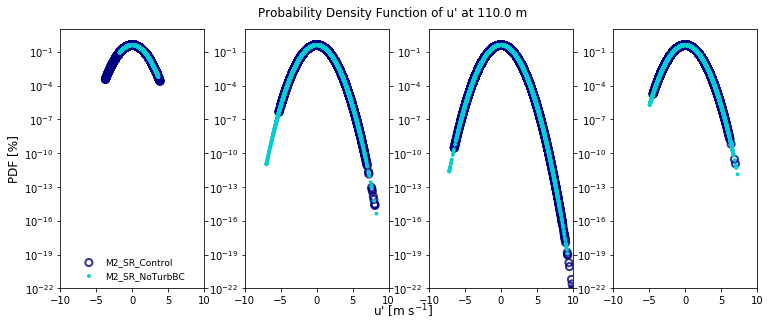

In [73]:
var = 'u'
varind = varns.index(var)
pdffig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.96,bottom=0.11,top=0.91,wspace=0.28)

plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)
plt1.set_yscale('log')
plt2.set_yscale('log')
plt3.set_yscale('log')
plt4.set_yscale('log')

plt1.tick_params(right=True,left=True)
plt2.tick_params(right=True,left=True)
plt3.tick_params(right=True,left=True)

plt1.set_ylabel('PDF [%]',size=12)
plt2.text(12,1e-24,"%s' [m s$^{-1}$]" % var,ha='center',va='center',size=12)
plt1.set_xlim(-10,10)
plt2.set_xlim(-10,10)
plt3.set_xlim(-10,10)
plt4.set_xlim(-10,10)

plt1.set_ylim(1e-22,1e1)
plt2.set_ylim(1e-22,1e1)
plt3.set_ylim(1e-22,1e1)
plt4.set_ylim(1e-22,1e1)

for cc in range(0,ncases):
    for tt in range(0,ntwrs):
#        if tt == 0: plt1.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
#        if tt == 1: plt2.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
#        if tt == 2: plt3.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
#        if tt == 3: plt4.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
        # SCATTER PLOT....
        if tt == 0: plt1.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc],label=cases[cc])
        if tt == 1: plt2.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc])
        if tt == 2: plt3.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc])
        if tt == 3: plt4.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc])
plt.suptitle("Probability Density Function of %s' at %3.1f m" % (var,twrheight))
plt1.legend(frameon=False,loc=8,fontsize=9)
plt.show(pdffig)

## Generate a table with all of the statistics

In [84]:
for var in varns:
    varind = varns.index(var)
    casestr = ['']*ncases*ntwrs
    twrstr  = ['']*ncases*ntwrs
    vmean   = np.zeros((ncases,ntwrs))
    vvari   = np.zeros((ncases,ntwrs))
    vskew   = np.zeros((ncases,ntwrs))
    vkurt   = np.zeros((ncases,ntwrs))
    count = 0
    for cc in range(0,ncases):
        for tt in range(0,ntwrs):
            casestr[count] = cases[cc]
            twrstr[count]  = twrs[tt]
            varpfs = np.sort(varpfull[varind,cc,tt,:])
            vmean[cc,tt] = lineavgfull[varind,cc,tt,lvl]
            vvari[cc,tt] = np.var(varpfs)
            vskew[cc,tt] = skew(varpfs)
            vkurt[cc,tt] = kurtosis(varpfs)
            count += 1
    df = pd.DataFrame(
        data={
            'Case':casestr,
            'Tower Number':twrstr,
            'Mean':vmean.flatten(),
            'Variance':vvari.flatten(),
            'Skewness':vskew.flatten(),
            'Kurtosis':vkurt.flatten(),
        })
    #df.to_latex('test.tex')
    df = df[['Case','Tower Number','Mean','Variance','Skewness','Kurtosis']]
    df.to_latex('/home/phawbeck/SOWFA/NWTC/SR_{}_statistics.tex'.format(var))
    print '/home/phawbeck/SOWFA/NWTC/SR_{}_statistics.tex'.format(var)
    print df

/home/phawbeck/SOWFA/NWTC/SR_u_statistics.tex
             Case  Tower Number      Mean  Variance  Skewness  Kurtosis
0   M2_SR_Control             1  6.519167  2.136641  0.526837 -0.858971
1   M2_SR_Control             3  6.656914  2.931765  0.767979  1.378594
2   M2_SR_Control             5  4.208550  5.695998  0.430980 -0.050655
3   M2_SR_Control             7  7.958094  3.642983  0.349228 -0.572392
4  M2_SR_NoTurbBC             1  6.438863  2.097867  0.629277 -0.965389
5  M2_SR_NoTurbBC             3  6.269938  3.113239  0.267275  1.094784
6  M2_SR_NoTurbBC             5  4.416778  6.395000  0.457261 -0.128292
7  M2_SR_NoTurbBC             7  8.103669  4.010025  0.340025 -0.489009
/home/phawbeck/SOWFA/NWTC/SR_v_statistics.tex
             Case  Tower Number      Mean  Variance  Skewness  Kurtosis
0   M2_SR_Control             1  0.009684  0.077994  0.047132  0.202803
1   M2_SR_Control             3  0.012791  0.487636 -0.265909  3.560874
2   M2_SR_Control             5  0.481332  1

## Plot average profiles of given variables

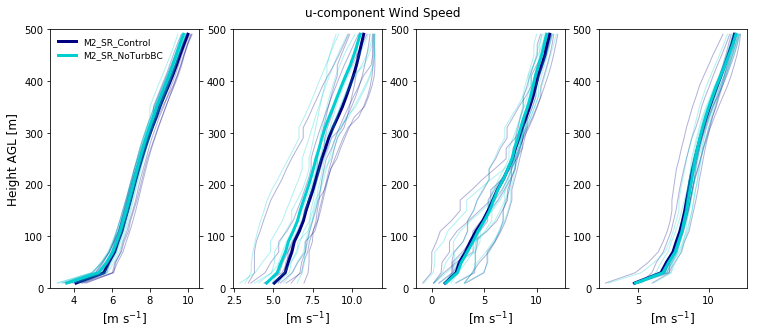

In [76]:
var = 'u'
varind = varns.index(var)
avgprfplt = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.96,bottom=0.11,top=0.91,wspace=0.23)
if var == 'u':
    ybot = 1e-1; ytop = 1e5
elif var == 'w':
    ybot = 1e-2; ytop = 1e4
ytics = [1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
xtics = [1e-3,1e-2,1e-1]
txtx = 6e-5

plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)

plt1.tick_params(right=True,left=True)
plt2.tick_params(right=True,left=True)
plt3.tick_params(right=True,left=True)

plt.suptitle('%s-component Wind Speed' % var)
plt1.set_ylabel('Height AGL [m]',size=12)
plt1.set_xlabel('[m s$^{-1}$]',size=12); plt2.set_xlabel('[m s$^{-1}$]',size=12)
plt3.set_xlabel('[m s$^{-1}$]',size=12); plt4.set_xlabel('[m s$^{-1}$]',size=12)

for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        for tw in np.arange(0,probeLine.ntowers):
            if tt == 0: plt1.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
            if tt == 1: plt2.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
            if tt == 2: plt3.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
            if tt == 3: plt4.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
        if tt == 0: plt1.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0,label=cases[cc])
        if tt == 1: plt2.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0)
        if tt == 2: plt3.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0)
        if tt == 3: plt4.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0)
plt1.set_ylim(0,500)
plt2.set_ylim(0,500)
plt3.set_ylim(0,500)
plt4.set_ylim(0,500)

plt1.legend(frameon=False,loc=2,fontsize=9)
plt.show(avgprfplt)